In [1]:
import gymnasium as gym
import numpy as np
from skimage import draw
import math

from typing import Optional

import os

import torch
from torch import nn
import torch.nn.functional as F
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def add_target(x, y, radius, num_rings, data):
    for i, r in zip(range(num_rings), reversed(range(num_rings))):
        ring_size = (r+1) * (radius/num_rings)
        if (i % 2) != 0:
            ring_color = (1, 1, 1)
        else:
            ring_color = (1, 0, 0)
        rr, cc = draw.disk((x, y), radius=ring_size, shape=data.shape)
        data[rr, cc, :] = ring_color
    return data

def get_new_target_data(x_dim, y_dim, min_radius, max_radius, min_rings, max_rings):
    radius = np.random.uniform(min_radius, max_radius)
        
    num_rings = np.random.uniform(min_rings, max_rings)

    min_x = radius
    max_x = x_dim - radius
    min_y = radius
    max_y = y_dim - radius
    x = np.random.uniform(min_x, max_x)
    y = np.random.uniform(min_y, max_y)
    
    return x, y, num_rings, radius

def circle_intersection(x1, y1, r1, x2, y2, r2):
  
    dist_centers = math.sqrt((x2-x1)**2 + (y2-y1)**2)
    radius_sum = r1 + r2
    
    if dist_centers < radius_sum:
        return True
    return False

def create_scene(x_dim = 1000, y_dim = 1000, 
                 num_targets=5, min_radius=50, max_radius=100, 
                 min_rings=5, max_rings=5):
    """
    Creates multiple new targets of varying radius, number of rings, and color
    
    Parameters:
    num_targets - the number of targets
    min_radius - the minimum radius of a target
    max_radius - the maximum radius of a target
    min_rings - the minimum number of rings on a target
    max_rings - the maximum number of rings on a target
    """
    scene_arr = np.zeros((x_dim, y_dim, 3)) + 1
    targets_metadata = []
    
    for n in range(num_targets):
        x, y, num_rings, radius = get_new_target_data(x_dim, y_dim, min_radius, max_radius, min_rings, max_rings)
        
        # Check for overlap with existing targets and redo target if it there is overlap        
        while True:
            is_overlapping = False
            
            # Check for overlap with existing targets
            for t in targets_metadata:
                targets_intersect = circle_intersection(t[0], t[1], t[2], x, y, radius)
                if targets_intersect:
                    is_overlapping = True
            
            # If there is overlap, redo the target and check again. If not, break and continue with rest of target creation
            if is_overlapping:
                x, y, num_rings, radius = get_new_target_data(x_dim, y_dim, min_radius, max_radius, min_rings, max_rings)    
            else:
                break
                
        scene_arr = add_target(x, y, radius=radius, num_rings=int(num_rings), data=scene_arr)
        targets_metadata.append((x, y, radius))
        
    return scene_arr, targets_metadata

def delete_target(x, y, radius, data):
    rr, cc = draw.disk((x, y), radius=radius, shape=data.shape)
    data[rr, cc, :] = (1, 1, 1)
    return data

def check_hit(action, metadata, data):
    for i, m in enumerate(metadata):
        x, y, radius = m
        dist = math.sqrt((action[0] - x)**2 + (action[1] - y)**2)
        if dist < radius:
            reward = (1 - (dist/radius))*10
            biggest_target_idx = np.argmax([m[2] for m in metadata])
            if i == biggest_target_idx:
                reward *= 3
            data = delete_target(x, y, radius, data)
            metadata.remove(m)
            return reward, metadata, data
    return -1, metadata, data

# data, metadata = create_scene()

# action = (194, 241)

# check_hit(action, metadata, data)

In [3]:
class Targets(gym.Env):
    def __init__(self, x_dim = 1000, y_dim = 1000, 
                 num_targets=5, min_radius=50, max_radius=100, max_ep_actions=100):
        self.num_targets = num_targets
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.min_radius = min_radius
        self.max_radius = max_radius
        self.max_ep_actions = num_targets + 1
        
        self.observation_space = gym.spaces.Dict(
            {
                "x_pos": gym.spaces.Box(low=0, high=x_dim, shape=(num_targets, 1), dtype=np.float32),
                "y_pos": gym.spaces.Box(low=0, high=y_dim, shape=(num_targets, 1), dtype=np.float32),
                "sizes": gym.spaces.Box(low=min_radius, high=max_radius, shape=(num_targets, 1), dtype=np.float32),
            }
        )

        self.action_space = gym.spaces.Box(low=0, high=1000, shape=(2,), dtype=np.float32)
        
        self.num_actions = 0
        
    def get_max_reward(self):
        return self.num_targets * 30
        
    def reset(self, seed: Optional[int] = None):
        super().reset(seed=seed)
        self.num_actions = 0
        np.random.seed(seed)
        
        self.data, self.metadata = create_scene(x_dim=self.x_dim, 
                                                num_targets=self.num_targets, 
                                                y_dim=self.y_dim, 
                                                min_radius=self.min_radius, 
                                                max_radius=self.max_radius)
        
        return self._get_obs()
    
    def step(self, action):
        reward, self.metadata, self.data = check_hit(action, self.metadata, self.data)
        self.num_actions += 1
        truncated = False
        info = self.data
        if (len(self.metadata) == 0) or self.num_actions >= self.max_ep_actions:
            terminated = True
        else:
            terminated = False
        observation = self._get_obs()
        return observation, reward, terminated, truncated, info
        
    def _get_obs(self):
        return torch.tensor(
            self.data.mean(axis=2, keepdims=True), dtype=torch.float32
        ).expand(1, -1, -1, -1).permute(0, 3, 1, 2)

In [4]:
temp_targets = Targets()
temp_data = temp_targets.reset()

In [5]:
temp_data.shape

torch.Size([1, 1, 1000, 1000])

In [6]:
temp_data = temp_data[0].permute(1, 2, 0)

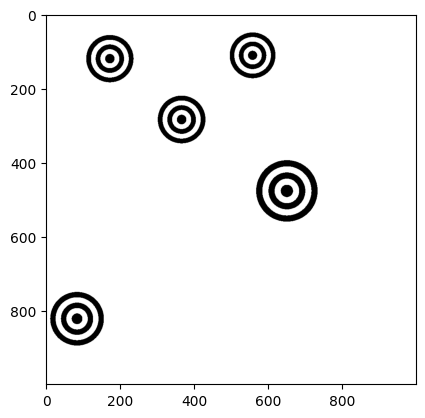

In [7]:
plt.imshow(temp_data, cmap='gray')

References for coding DDPG agent
- https://keras.io/examples/rl/ddpg_pendulum/
- https://arxiv.org/pdf/1509.02971
- https://towardsdatascience.com/deep-deterministic-policy-gradients-explained-2d94655a9b7b

In [8]:
class Critic(nn.Module):
    def __init__(self, action_dim):
        super(Critic, self).__init__()
        
        self.state_conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.state_conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.state_pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.state_flatten1 = nn.Flatten()
        self.state_linear1 = nn.Linear(800, 64)

        self.action_linear1 = nn.Linear(action_dim, 64)
        
        self.linear1 = nn.Linear(128, 256)
        
        self.out = nn.Linear(256, action_dim)

    def forward(self, state, action):
        state_x = F.relu(self.state_conv1(state))
        state_x = self.state_pool(state_x)
        state_x = F.relu(self.state_conv2(state_x))
        state_x = self.state_pool(state_x)
        state_x = self.state_flatten1(state_x)
        state_x = F.relu(self.state_linear1(state_x))
        
        action_x = F.relu(self.action_linear1(action))
        
        x = torch.cat([state_x, action_x], dim=1)
        x = F.relu(self.linear1(x))
        
        x = self.out(x)

        return x
    
class Actor(nn.Module):
    def __init__(self, action_dim):
        super(Actor, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.flatten1 = nn.Flatten()
        self.linear1 = nn.Linear(800, 64)
        
        self.out = nn.Linear(64, action_dim)
        self.out.weight.data = nn.init.uniform_(self.out.weight, -0.003, 0.003)
        
    def forward(self, state):
        x = F.relu(self.conv1(state))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.flatten1(x)
        x = F.relu(self.linear1(x))
        x = self.out(x)
        x = (F.tanh(x) + 1) * 50
        
        return x

In [9]:
temp_actor = Actor(2)
temp_actor.forward(torch.rand(1, 1, 100, 100))

tensor([[47.7332, 51.9057]], grad_fn=<MulBackward0>)

In [10]:
temp_critic = Critic(2)
temp_critic.forward(torch.rand(1, 1, 100, 100), torch.rand(1, 2))

tensor([[0.0066, 0.1101]], grad_fn=<AddmmBackward0>)

In [11]:
def policy(state, actor_model, decay_rate, ep, action_lower_bound, action_upper_bound):
    actions = actor_model(state)
    
    noise_decay = math.exp(-decay_rate * ep)
    noise = torch.tensor(np.random.uniform(action_lower_bound*0.5, action_upper_bound*0.5, actions.shape))
    actions += (noise * noise_decay)
    
    bounded_action = torch.clamp(actions, action_lower_bound, action_upper_bound)
    
    return bounded_action[0]

In [12]:
temp_actor = Actor(2)
policy(torch.rand(1, 1, 100, 100), temp_actor, 0.05, 1, 0, 100)

tensor([54.1620, 56.7118], grad_fn=<SelectBackward0>)

In [13]:
class Buffer:
    def __init__(self, state_dim, num_actions, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells num of times record() was called.
        self.buffer_counter = 0

        state_buffer_dim = [self.buffer_capacity]
        state_buffer_dim.extend(list(state_dim))
        
        self.state_buffer = torch.zeros(state_buffer_dim)
        self.action_buffer = torch.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = torch.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = torch.zeros(state_buffer_dim)

    # Takes (s,a,r,s') observation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1
        
    def sample(self, size):
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch = np.random.choice(record_range, size)
        
        states = self.state_buffer[batch]
        actions = self.action_buffer[batch]
        rewards = self.reward_buffer[batch]
        next_states = self.next_state_buffer[batch]
        
        return states, actions, rewards, next_states
    
def copy_network(src, target):
    for src_param, target_param in zip(src.parameters(), target.parameters()):
        target_param.data.copy_(src_param.data)

def update_target(src, target, tau):
    for src_param, target_param in zip(src.parameters(), target.parameters()):
        target_param.data.copy_(tau * src_param.data + (1.0 - tau) * target_param.data)

In [14]:
# if torch.cuda.is_available():
#     device = torch.device("cuda")
# else:
#     device = torch.device("cpu")

env_dim = 100
targets_env = Targets(x_dim=env_dim, y_dim=env_dim, num_targets=1, min_radius=10, max_radius=20, max_ep_actions=200)

state_dim = (1, env_dim, env_dim)
num_actions = 2

actor_lr = 0.001
actor = Actor(num_actions)
actor_optim = torch.optim.Adam(actor.parameters(), lr=actor_lr)

target_actor = Actor(num_actions)
copy_network(actor, target_actor)

critic_lr = 0.002
critic = Critic(num_actions)
critic_optim = torch.optim.Adam(critic.parameters(), lr=critic_lr)
critic_criterion = nn.MSELoss()

target_critic = Critic(num_actions)
copy_network(critic, target_critic)

buffer = Buffer(state_dim, num_actions, buffer_capacity=10000)

num_episodes = 5000
batch_size = 64
gamma = 0.99
tau = 0.01
noise_decay_rate=1e-3

episode_rewards = []
for ep in range(num_episodes):
    state = targets_env.reset()
    episode_reward = 0
    
    while True:
        action = policy(state, actor, noise_decay_rate, ep+1, 0, env_dim)
        next_state, reward, terminated, truncated, info = targets_env.step(action.detach().numpy())
        buffer.record((state, action, reward, next_state))
        
        if buffer.buffer_counter > batch_size:
            buffer_states, buffer_actions, buffer_rewards, buffer_next_states = buffer.sample(batch_size)
            
            target_actions = target_actor.forward(buffer_next_states)
            target_q_values = target_critic.forward(buffer_next_states, target_actions)
            
            q_prime_values = buffer_rewards + gamma * target_q_values
            
            q_values = critic.forward(buffer_states, buffer_actions.detach())
            
            critic_loss = critic_criterion(q_values, q_prime_values)
            critic_optim.zero_grad()
            critic_loss.backward()
            critic_optim.step()
            
            q_values = critic.forward(buffer_states, actor.forward(buffer_states))
            actor_loss = -q_values.mean()
            actor_optim.zero_grad()
            actor_loss.backward()
            actor_optim.step()
            
            for src_param, target_param in zip(actor.parameters(), target_actor.parameters()):
                target_param.data.copy_(tau * src_param.data + (1.0 - tau) * target_param.data)
            for src_param, target_param in zip(critic.parameters(), target_critic.parameters()):
                target_param.data.copy_(tau * src_param.data + (1.0 - tau) * target_param.data)
            
        state = next_state
        episode_reward += reward
        
        if terminated:
            break
        
    episode_rewards.append(episode_reward)
    if ep % 50 == 0:
        print(f"Episode {ep}, Mean Reward of Last 50 Episodes: {np.mean(episode_rewards[-50:])}, noise_decay: {math.exp(-noise_decay_rate * ep)}")

Episode 0, Mean Reward of Last 50 Episodes: -2.0, noise_decay: 1.0
Episode 50, Mean Reward of Last 50 Episodes: -1.5618615296349885, noise_decay: 0.951229424500714
Episode 100, Mean Reward of Last 50 Episodes: -2.0, noise_decay: 0.9048374180359595
Episode 150, Mean Reward of Last 50 Episodes: -2.0, noise_decay: 0.8607079764250578
Episode 200, Mean Reward of Last 50 Episodes: -2.0, noise_decay: 0.8187307530779818
Episode 250, Mean Reward of Last 50 Episodes: -1.2758294144748006, noise_decay: 0.7788007830714049
Episode 300, Mean Reward of Last 50 Episodes: -0.865180518045112, noise_decay: 0.7408182206817179
Episode 350, Mean Reward of Last 50 Episodes: -1.7177255666052138, noise_decay: 0.7046880897187134
Episode 400, Mean Reward of Last 50 Episodes: -0.8402348550216132, noise_decay: 0.6703200460356393
Episode 450, Mean Reward of Last 50 Episodes: -1.249999499136563, noise_decay: 0.6376281516217733
Episode 500, Mean Reward of Last 50 Episodes: -1.4693286795010574, noise_decay: 0.606530659

KeyboardInterrupt: 

<Axes: >

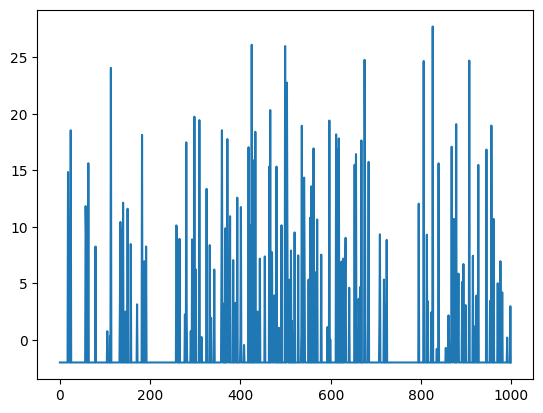

In [ ]:
import seaborn as sns
sns.lineplot(x=list(range(len(episode_rewards))), y=episode_rewards)

In [16]:
actor.forward(targets_env._get_obs())

tensor([[0., 0.]], grad_fn=<MulBackward0>)